In [1]:
import numpy as np
import json
import scipy
from scipy import linalg, optimize,special


In [2]:
import numpy as np
import matplotlib.pyplot  as  plt
from matplotlib.ticker import MaxNLocator
from scipy.special import binom
from scipy.optimize import curve_fit
from matplotlib.markers import MarkerStyle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
fparams1 =  {'xtick.labelsize': 32,
            'ytick.labelsize': 32,
            'axes.labelsize': 36,
            'axes.titlesize': 32,
            'font.size': 32,
            'legend.fontsize': 30,
            'text.usetex': True,
            'legend.frameon' : False,
            'svg.fonttype': 'path',
            'lines.linewidth': 2.5,
             
             'lines.markersize': 10
            }

fparams2 =  {'xtick.labelsize': 28,
            'ytick.labelsize': 28,
            'axes.labelsize': 32,
            'axes.titlesize': 28,
            'font.size': 28,
            'legend.fontsize': 26,
            'text.usetex': True,
            'legend.frameon' : False,
            'svg.fonttype': 'path',
            'lines.linewidth': 2.5,
            
            'lines.markersize': 10}

fparams3 =  {'xtick.labelsize': 22,
            'ytick.labelsize': 22,
            'axes.labelsize': 26,
            'axes.titlesize': 22,
            'font.size': 22,
            'legend.fontsize': 20,
            'text.usetex': True,
            'legend.frameon' : False,
            'svg.fonttype': 'path',
            'lines.linewidth': 2.5,
             
            'lines.markersize': 10}

In [4]:
#variables

omegas=[0.28,0.38,0.63,0.86] #qubits frequency

nr=100 #number of disorder realizations
nb_qubits=4 #system size
T=[2.5,5,10] #time to which the computation is performed

initial_states=['ground_state','highest_energy_state']

backend = 'ibm_hanoi'
sessions=[['thermalization 1','thermalization 2','thermalization 3'],['thermalization 4','thermalization 5','thermalization 6']]

nb_twirls_RC=100 #number of RC circuits per disorder realization

nb_shots_RC=1000 #number of shots per circuit

nb_shots_sim=100000#number of shots used for the noiseless simulation

In [6]:
#load populations
pop_exact=[np.load('data/populations/population_exact_dynamics_{}.npy'.format(initial_state)) for initial_state in initial_states]
pop_noiseless=[np.load('data/populations/population_noiseless_{}.npy'.format(initial_state)) for initial_state in initial_states]
pop_RC=[np.load('data/populations/population_RC_{}.npy'.format(initial_state))for initial_state in initial_states]
pop_ZNE3=[np.load('data/populations/population_ZNE3_{}.npy'.format(initial_state))for initial_state in initial_states]


In [7]:
t_array=np.arange(0,15,0.01)#time array for the exact dynamics

#average of the different populations over the different disorder realization and cRC version (if needed)

avg_pop_exact=list(list(list(np.mean(np.array(pop_exact[i])[:,np.where(t_array==t),p]) for p in range(2**nb_qubits)) for t in T) for i in range(len(initial_states)))

avg_pop_noiseless=list(list(list(np.mean(pop_noiseless[i][s][p]) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))


mean_pop_RC=list(list(list(list(np.mean(pop_RC[i][s][p][d]) for d in range(nr)) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
avg_pop_RC=list(list(list(np.mean(mean_pop_RC[i][s][p]) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))

mean_pop_ZNE3=list(list(list(list(np.mean(pop_ZNE3[i][s][p][d]) for d in range(nr)) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
avg_pop_ZNE3=list(list(list(np.mean(mean_pop_ZNE3[i][s][p]) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))

#final standard deviation corresponding to the different uncertainties (finite disorder realization, finite cRC, shot noise)
                           
std_pop_exact=list(list(list(np.std(np.array(pop_exact[i])[:,np.where(t_array==t),p],ddof=1)/np.sqrt(nr) for p in range(2**nb_qubits)) for t in T) for i in range(len(initial_states)))
    
shot_noise_noiseless=list(list(list(list(pop_noiseless[i][s][p][d]*(1-pop_noiseless[i][s][p][d])/nb_shots_sim for d in range(nr)) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
avg_shot_noise_noiseless=list(list(list(np.mean(shot_noise_noiseless[i][s][p]) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_pop_noiseless=list(list(list(np.sqrt(np.var(np.array(pop_noiseless[i][s][p]),ddof=1)/nr+avg_shot_noise_noiseless[i][s][p]) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))

shot_noise_RC=list(list(list(list(list(pop_RC[i][s][p][d][k]*(1-pop_RC[i][s][p][d][k])/nb_shots_RC for k in range(nb_twirls_RC)) for d in range(nr)) for p in range(2**nb_qubits)) for s in range(len(sessions[i])))  for i in range(len(initial_states)))
avg_shot_noise_RC=list(list(list(list(np.mean(shot_noise_RC[i][s][p][d])/nb_twirls_RC for d in range(nr)) for p in range(2**nb_qubits))for s in range(len(sessions[i])))for i in range(len(initial_states)))
RC_noise=list(list(list(list(np.var(pop_RC[i][s][p][d],ddof=1)/nb_twirls_RC+avg_shot_noise_RC[i][s][p][d] for d in range(nr)) for p in range(2**nb_qubits))for s in range(len(sessions[i])))for i in range(len(initial_states)))
avg_RC_noise=list(list(list(np.sqrt(np.mean(RC_noise[i][s][p])/nr) for p in range(2**nb_qubits)) for s in range(len(sessions[i])))for i in range(len(initial_states)))
std_pop_RC=list(list(list(np.sqrt(np.var(mean_pop_RC[i][s][p],ddof=1)/nr+avg_RC_noise[i][s][p]**2) for p in range(2**nb_qubits)) for s in range(len(sessions[i])))for i in range(len(initial_states)))

shot_noise_ZNE3=list(list(list(list(list(pop_ZNE3[i][s][p][d][k]*(1-pop_ZNE3[i][s][p][d][k])/nb_shots_RC for k in range(nb_twirls_RC)) for d in range(nr)) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
avg_shot_noise_ZNE3=list(list(list(list(np.mean(shot_noise_ZNE3[i][s][p][d])/nb_twirls_RC for d in range(nr)) for p in range(2**nb_qubits))for s in range(len(sessions[i])))for i in range(len(initial_states)))
ZNE3_noise=list(list(list(list(np.var(pop_ZNE3[i][s][p][d],ddof=1)/nb_twirls_RC+avg_shot_noise_ZNE3[i][s][p][d] for d in range(nr)) for p in range(2**nb_qubits))for s in range(len(sessions[i]))) for i in range(len(initial_states)))
avg_ZNE3_noise=list(list(list(np.sqrt(np.mean(ZNE3_noise[i][s][p])/nr) for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_pop_ZNE3=list(list(list(np.sqrt(np.var(mean_pop_ZNE3[i][s][p],ddof=1)/nr+avg_ZNE3_noise[i][s][p]**2) for p in range(2**nb_qubits)) for s in range(len(sessions[i])))for i in range(len(initial_states)))




In [8]:
import math
def thermal_distrib(energies,beta):
    s=sum(np.exp(-beta*energy) for energy in energies)
    return [np.exp(-beta*energy)/s for energy in energies]

def thermal_distrib_global_depo(energies,beta,fidelity,nb_qubits=4):
    s=sum(np.exp(-beta*energy) for energy in energies)
    return [(fidelity*np.exp(-beta*energy)/s+(1-fidelity)/2**nb_qubits) for energy in energies]


def thermal_distrib_func(energy,beta):
    s=sum(np.exp(-beta*en) for en in many_omegas)
    return np.exp(-beta*energy)/s

def thermal_distrib_global_depo_func(energy,beta,fidelity):
    nb_qubits=4
    s=sum(np.exp(-beta*en) for en in many_omegas)
    return (fidelity*np.exp(-beta*energy)/s+(1-fidelity)/2**nb_qubits)


#many-body energies
many_omegas=[sum((int(b)-1/2)*omegas[nb_qubits-1-i] for i,b in enumerate([0]*(nb_qubits-len(bin(k)[2:]))+list(bin(k)[2:])))
             for k in range(2**nb_qubits)]

print(many_omegas)  

#fit with the thermal distribution
fit_exact=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
cov_exact=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
fit_noiseless=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
cov_noiseless=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
fit_RC=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
cov_RC=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
fit_ZNE3=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
cov_ZNE3=[[None for _ in range(len(sessions[s]))] for s in range(len(sessions))]
for i in range(len(initial_states)):
    for s in range(len(sessions[i])):
        fit_exact[i][s],cov_exact[i][s]=scipy.optimize.curve_fit(thermal_distrib_func,many_omegas,avg_pop_exact[i][s],sigma=std_pop_exact[i][s],absolute_sigma=True)
        
        fit_noiseless[i][s],cov_noiseless[i][s]=scipy.optimize.curve_fit(thermal_distrib_func,many_omegas,avg_pop_noiseless[i][s],sigma=std_pop_noiseless[i][s],absolute_sigma=True)
        fit_RC[i][s],cov_RC[i][s]=scipy.optimize.curve_fit(thermal_distrib_global_depo_func,many_omegas,avg_pop_RC[i][s],sigma=std_pop_RC[i][s],absolute_sigma=True,bounds=([-math.inf,0],[math.inf,1]))
        fit_ZNE3[i][s],cov_ZNE3[i][s]=scipy.optimize.curve_fit(thermal_distrib_global_depo_func,many_omegas,avg_pop_ZNE3[i][s],sigma=std_pop_ZNE3[i][s],absolute_sigma=True,bounds=([-math.inf,0],[math.inf,1]))


[-1.0750000000000002, -0.795, -0.695, -0.4149999999999999, -0.445, -0.16499999999999998, -0.065, 0.21500000000000002, -0.21500000000000002, 0.065, 0.16499999999999998, 0.445, 0.4149999999999999, 0.695, 0.795, 1.0750000000000002]


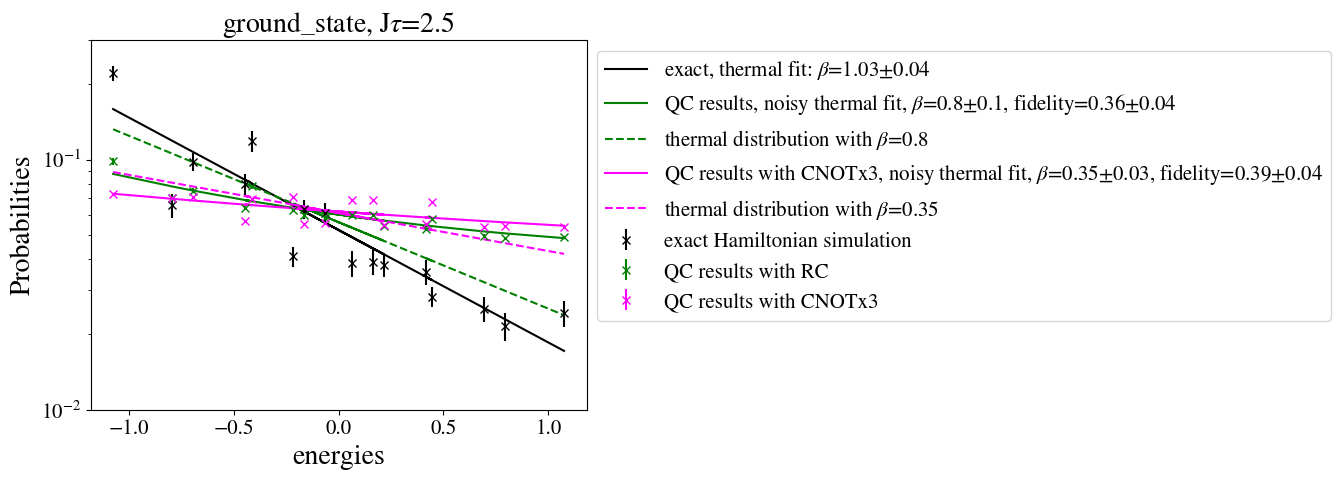

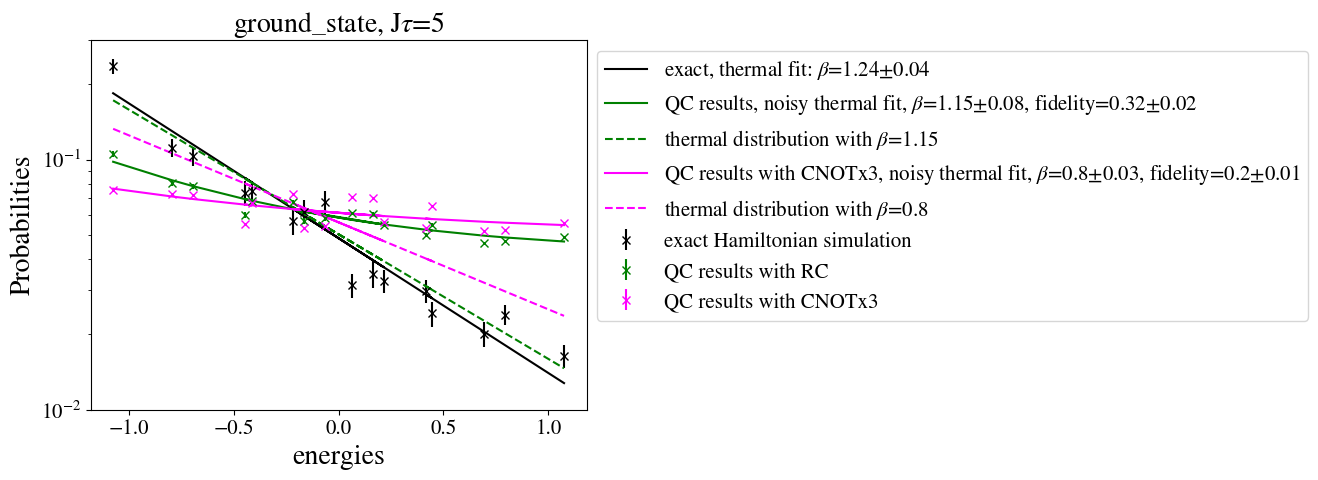

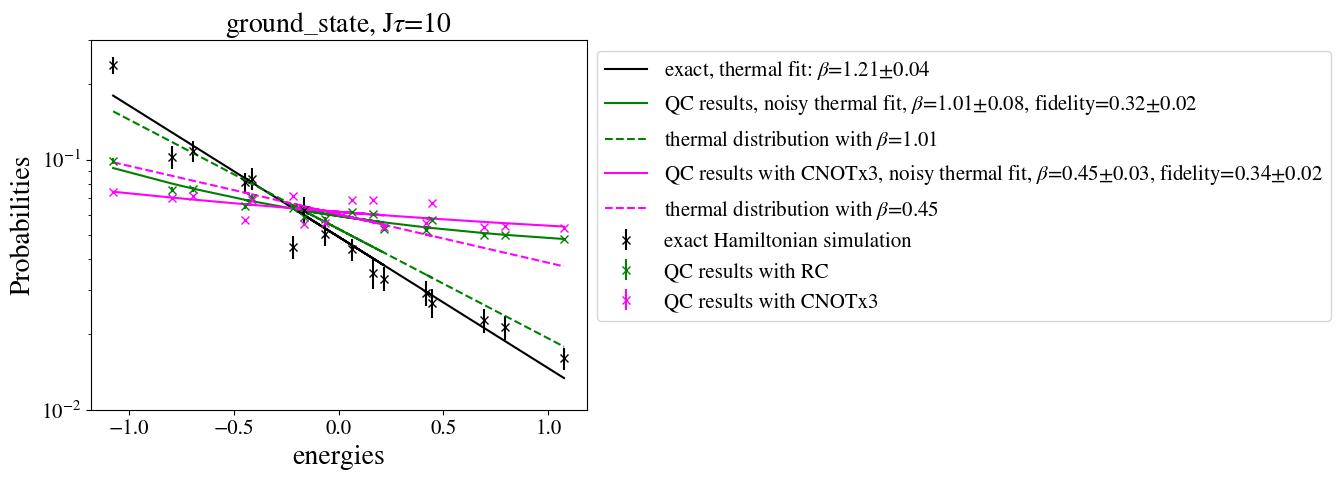

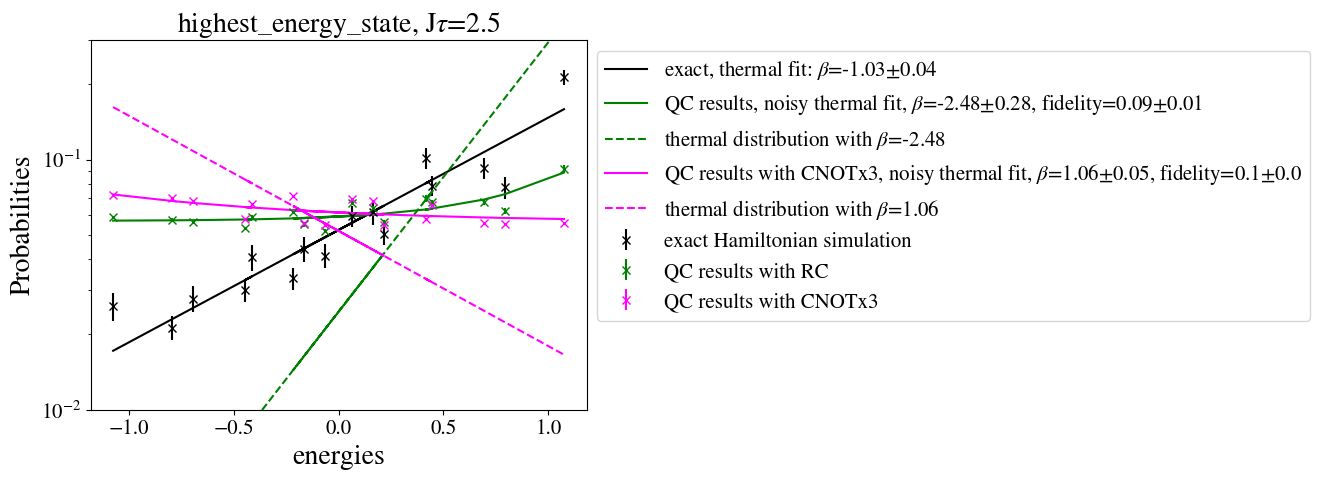

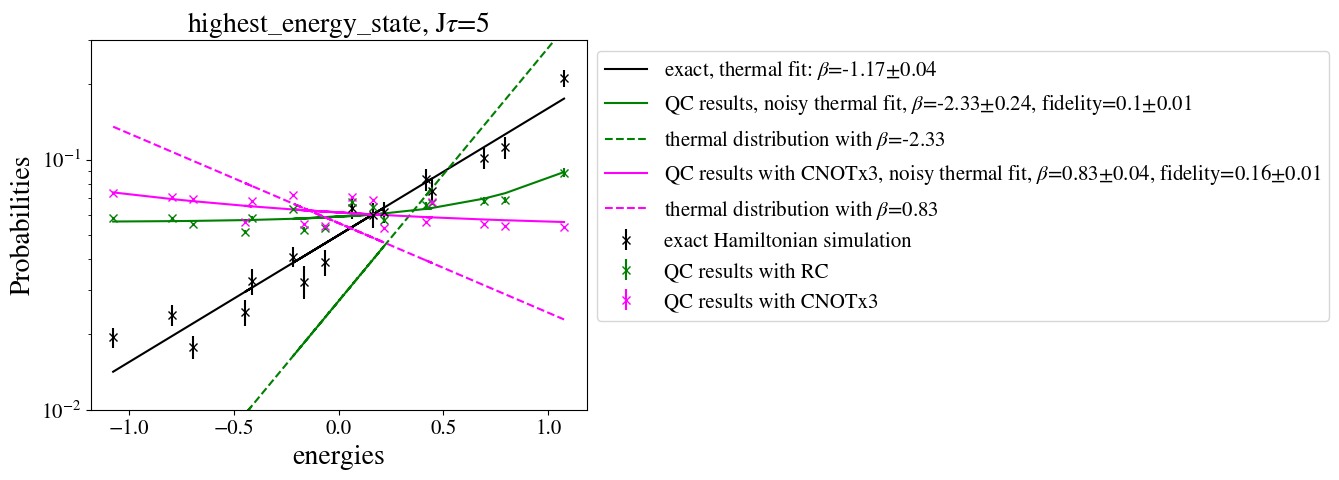

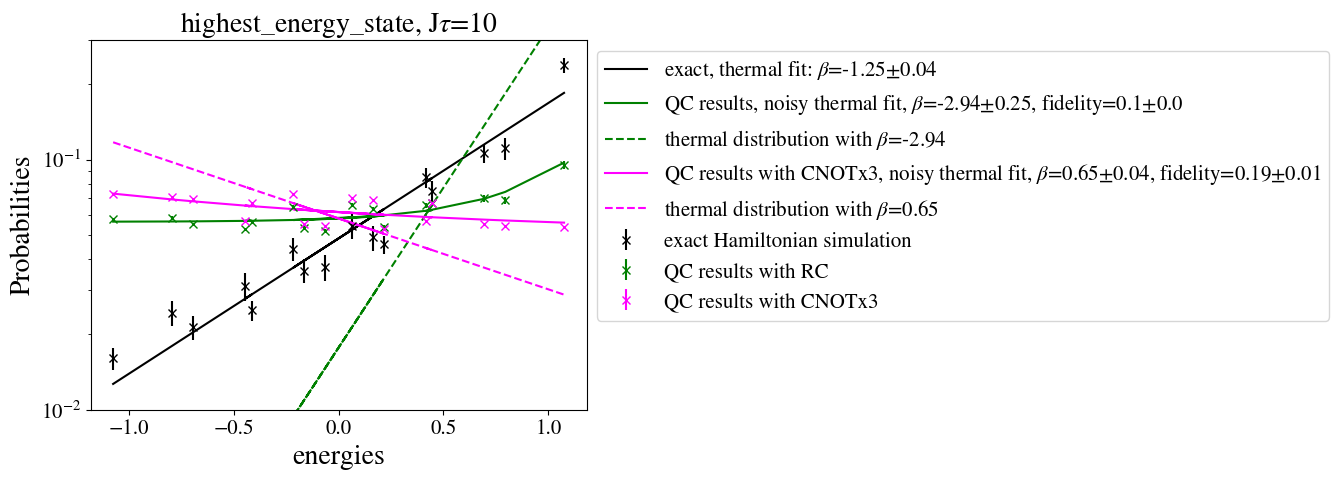

In [9]:
import matplotlib.pyplot as plt


plt.rcParams['font.size'] = 15   
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

for i in range(len(initial_states)):
    for s in range(len(sessions[i])):
        plt.errorbar(many_omegas,avg_pop_exact[i][s],fmt='x',yerr=std_pop_exact[i][s],color='black',label='exact Hamiltonian simulation')
        #plt.errorbar(many_omegas,avg_pop_noiseless[s],fmt='x',yerr=std_pop_noiseless[s],color='red',label='recompilation noiseless simulation')

        plt.errorbar(many_omegas,avg_pop_RC[i][s],fmt='x',yerr=std_pop_RC[i][s],color='green',label='QC results with RC')
        plt.errorbar(many_omegas,avg_pop_ZNE3[i][s],fmt='x',yerr=std_pop_ZNE3[i][s],color='magenta',label='QC results with CNOTx3')

        plt.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[i][s][0]),'-',color='black',label=r'exact, thermal fit: $\beta$='+str(round(fit_exact[i][s][0],2))+'$\pm$'+str(round(np.sqrt(cov_exact[i][s][0][0]),2)))
        #plt.plot(many_omegas,thermal_distrib(many_omegas,fit_noiseless[i][s][0]),'-',color='red',label=r'recompilation noiseless, thermal fit: $\beta$='+str(round(fit_noiseless[s][0],2))+'$\pm$'+str(round(np.sqrt(cov_noiseless[s][0][0]),2)))

        plt.plot(many_omegas,thermal_distrib_global_depo(many_omegas,fit_RC[i][s][0],fit_RC[i][s][1]),'-',color='green',label=r'QC results, noisy thermal fit, $\beta$='+str(round(fit_RC[i][s][0],2))+'$\pm$'+str(round(np.sqrt(cov_RC[i][s][0][0]),2))+', fidelity='+str(round(fit_RC[i][s][1],2))+'$\pm$'+str(round(np.sqrt(cov_RC[i][s][1][1]),2)))
        plt.plot(many_omegas,thermal_distrib(many_omegas,fit_RC[i][s][0]),'--',color='green',label=r'thermal distribution with $\beta$='+str(round(fit_RC[i][s][0],2)))

        plt.plot(many_omegas,thermal_distrib_global_depo(many_omegas,fit_ZNE3[i][s][0],fit_ZNE3[i][s][1]),'-',color='magenta',label=r'QC results with CNOTx3, noisy thermal fit, $\beta$='+str(round(fit_ZNE3[i][s][0],2))+'$\pm$'+str(round(np.sqrt(cov_ZNE3[i][s][0][0]),2))+', fidelity='+str(round(fit_ZNE3[i][s][1],2))+'$\pm$'+str(round(np.sqrt(cov_ZNE3[i][s][1][1]),2)))
        plt.plot(many_omegas,thermal_distrib(many_omegas,fit_ZNE3[i][s][0]),'--',color='magenta',label=r'thermal distribution with $\beta$='+str(round(fit_ZNE3[i][s][0],2)))


        plt.yscale('log')
        plt.ylim(0.01,0.3)
        plt.xlabel('energies',fontsize=20)
        plt.ylabel('Probabilities',fontsize=20)
        sigma=1#standard deviation of the coupling strength's gaussian distribution
        plt.title(label=initial_states[i]+r', J$\tau$='+str(round(sigma*T[s],2)),fontsize=20)
        plt.legend(bbox_to_anchor=(1, 1.))
        
        plt.show()

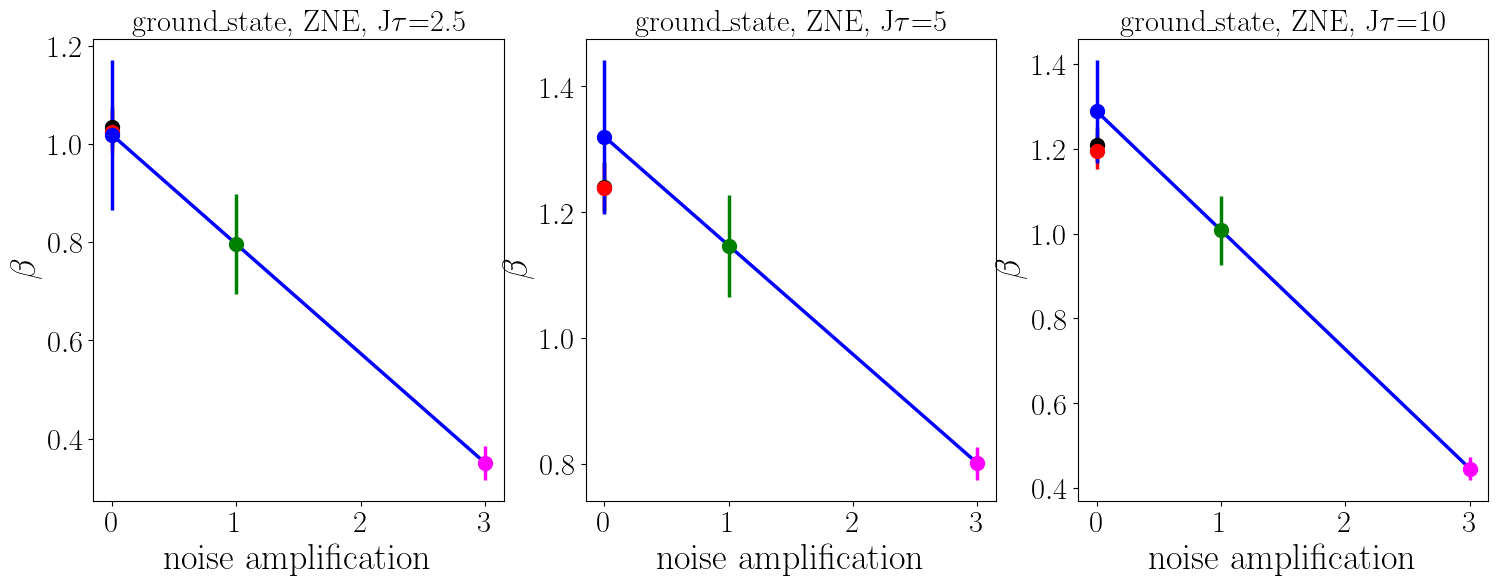

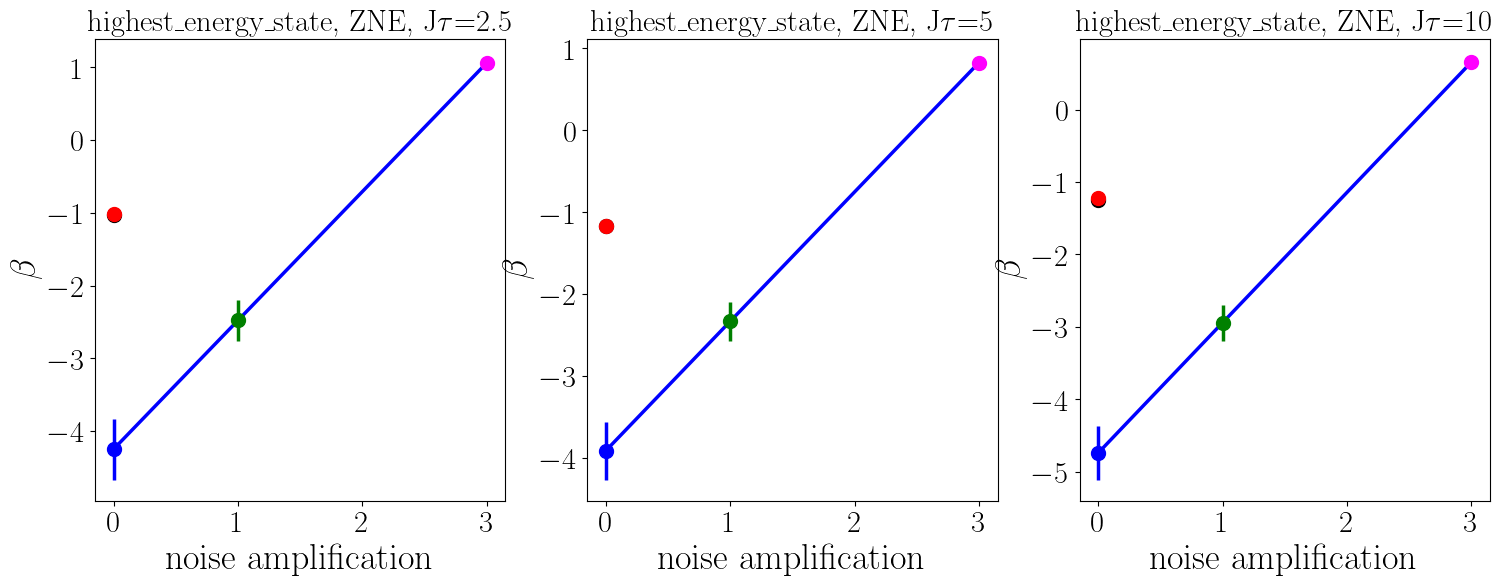

In [15]:
#ZNE 
def linear(x,a,b):
    return a*x+b
ZNE_beta=[[0 for _ in range(len(sessions[s]))] for s in range(len(sessions))]
std_beta_ZNE=[[0 for _ in range(len(sessions[s]))] for s in range(len(sessions))]
ZNE_slope=[[0 for _ in range(len(sessions[s]))] for s in range(len(sessions))]

for i in range(len(initial_states)):
    fig, axs = plt.subplots(1, 3,figsize=(18,6))

    for s in range(len(sessions[i])):
    
        r=[1,3]
        beta=[fit_RC[i][s][0],fit_ZNE3[i][s][0]]
        axs[s].errorbar(r[0],beta[0],fmt='o',yerr=np.sqrt(cov_RC[i][s][0][0]),color='green',label='fit QC with RC')
        axs[s].errorbar(r[1],beta[1],fmt='o',yerr=np.sqrt(cov_ZNE3[i][s][0][0]),color='magenta',label='fit QC with RC and noise amplification')
        axs[s].errorbar(0,fit_exact[i][s][0],fmt='o',yerr=np.sqrt(cov_exact[i][s][0][0]),color='black',label=r'exact $\beta$')
        axs[s].errorbar(0,fit_noiseless[i][s][0],fmt='o',yerr=np.sqrt(cov_noiseless[i][s][0][0]),color='r',label=r'recompiled noiseless $\beta$')
        lin1,covlin1=scipy.optimize.curve_fit(linear,r,beta,sigma=[np.sqrt(cov_RC[i][s][0][0]),np.sqrt(cov_ZNE3[i][s][0][0])],absolute_sigma=True)
        ZNE_beta[i][s]=lin1[1]
        ZNE_slope[i][s]=lin1[0]
        std_beta_ZNE[i][s]=np.sqrt(covlin1[1][1])
        e=np.arange(0,3,0.01)
        axs[s].plot(e,lin1[0]*e+lin1[1],'-',color='blue',label='linear fit')
        axs[s].errorbar(0,lin1[1],yerr=std_beta_ZNE[i][s],fmt='o',color='blue',label='ZNE value')

        axs[s].set_title(initial_states[i]+r', ZNE, J$\tau$='+str(round(sigma*T[s],2)))
    for ax in axs.flat:
        ax.set(ylabel=r'$\beta$', xlabel='noise amplification')

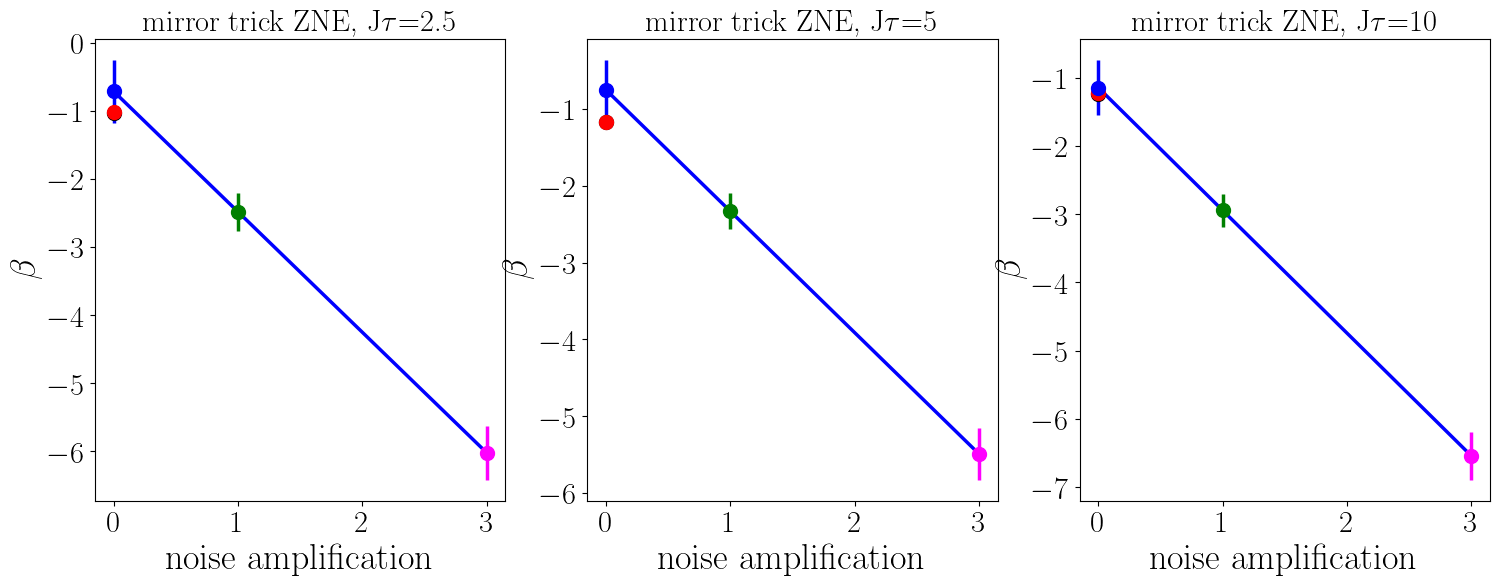

In [16]:
#ZNE mirror trick
def linear(x,a,b):
    return a*x+b
ZNE_beta_mirror=[0]*len(sessions[1])
ZNE_slope_mirror=[0]*len(sessions[1])
std_beta_ZNE_mirror=[0]*len(sessions[1])
fig, axs = plt.subplots(1, 3,figsize=(18,6))
fit_ZNE3_mirror=[[fit_RC[1][s][0]-np.abs(fit_RC[1][s][0]-fit_ZNE3[1][s][0]),fit_ZNE3[1][s][1]]  for s in range(len(sessions[1]))] #symmetric mirror temperature
std_ZNE3_mirror=[np.sqrt(2*cov_RC[1][s][0][0]+cov_ZNE3[1][s][0][0]) for s in range(len(sessions[1]))] #symmetric mirror temperature

for s in range(len(sessions[1])):
    
    r=[1,3]
    beta=[fit_RC[1][s][0],fit_ZNE3_mirror[s][0]]
    axs[s].errorbar(r[0],beta[0],fmt='o',yerr=np.sqrt(cov_RC[1][s][0][0]),color='green',label='fit QC with RC')
    axs[s].errorbar(r[1],beta[1],fmt='o',yerr=std_ZNE3_mirror[s],color='magenta',label='fit QC with RC and noise amplification')
    axs[s].errorbar(0,fit_exact[1][s][0],fmt='o',yerr=np.sqrt(cov_exact[1][s][0][0]),color='black',label=r'exact $\beta$')
    axs[s].errorbar(0,fit_noiseless[1][s][0],fmt='o',yerr=np.sqrt(cov_noiseless[1][s][0][0]),color='r',label=r'recompiled noiseless $\beta$')
    
    lin1,covlin1=scipy.optimize.curve_fit(linear,r,beta,sigma=[np.sqrt(cov_RC[1][s][0][0]),std_ZNE3_mirror[s]],absolute_sigma=True)
    ZNE_beta_mirror[s]=lin1[1]
    ZNE_slope_mirror[s]=lin1[0]
    std_beta_ZNE_mirror[s]=np.sqrt(covlin1[1][1])
    e=np.arange(0,3,0.01)
    axs[s].plot(e,lin1[0]*e+lin1[1],'-',color='blue',label='linear fit')
    axs[s].errorbar(0,lin1[1],yerr=std_beta_ZNE_mirror[s],fmt='o',color='blue',label='ZNE value')
    
    axs[s].set_title(r'mirror trick ZNE, J$\tau$='+str(round(sigma*T[s],2)))
for ax in axs.flat:
    ax.set(ylabel=r'$\beta$', xlabel='noise amplification')
    

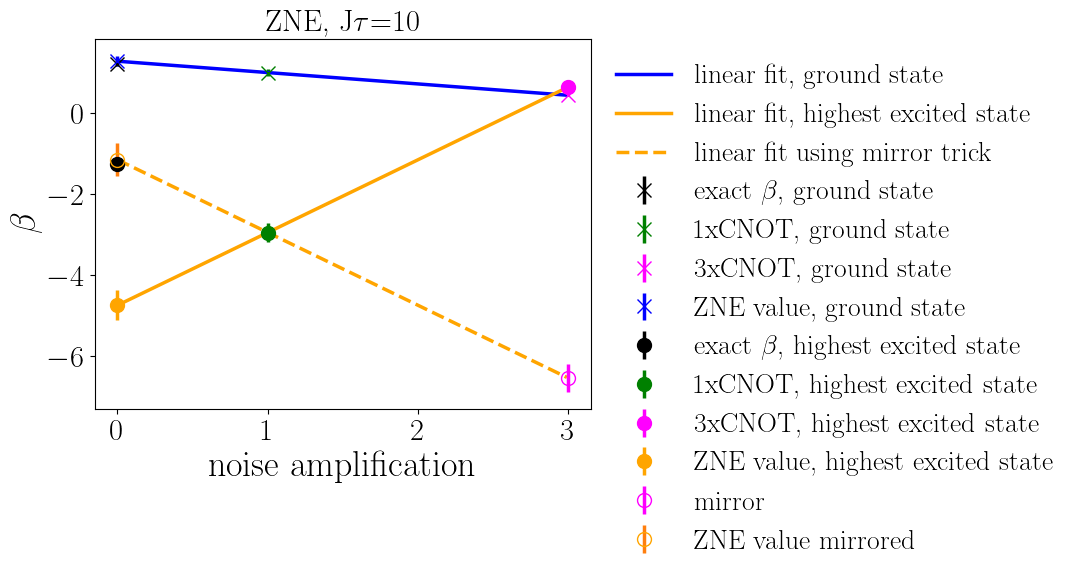

In [17]:
r=[1,3]
#ground state
plt.errorbar(0,fit_exact[0][2][0],fmt='x',yerr=np.sqrt(cov_exact[0][2][0][0]),color='black',label=r'exact $\beta$, ground state')
plt.errorbar(r[0],fit_RC[0][2][0],fmt='x',yerr=np.sqrt(cov_RC[0][2][0][0]),color='green',label='1xCNOT, ground state')
plt.errorbar(r[1],fit_ZNE3[0][2][0],fmt='x',yerr=np.sqrt(cov_ZNE3[0][2][0][0]),color='magenta',label='3xCNOT, ground state')
plt.plot(e,ZNE_slope[0][2]*e+ZNE_beta[0][2],'-',color='blue',label='linear fit, ground state')
plt.errorbar(0,ZNE_beta[0][2],yerr=std_beta_ZNE[0][2],fmt='x',color='blue',label='ZNE value, ground state')


plt.errorbar(0,fit_exact[1][2][0],fmt='o',yerr=np.sqrt(cov_exact[1][2][0][0]),color='black',label=r'exact $\beta$, highest excited state')
plt.errorbar(r[0],fit_RC[1][2][0],fmt='o',yerr=np.sqrt(cov_RC[1][2][0][0]),color='green',label='1xCNOT, highest excited state')
plt.errorbar(r[1],fit_ZNE3[1][2][0],fmt='o',yerr=np.sqrt(cov_ZNE3[1][2][0][0]),color='magenta',label='3xCNOT, highest excited state')
plt.plot(e,ZNE_slope[1][2]*e+ZNE_beta[1][2],'-',color='orange',label='linear fit, highest excited state')
plt.errorbar(0,ZNE_beta[1][2],yerr=std_beta_ZNE[1][2],fmt='o',color='orange',label='ZNE value, highest excited state')

plt.plot(e,ZNE_slope_mirror[2]*e+ZNE_beta_mirror[2],'--',color='orange',label='linear fit using mirror trick')
plt.errorbar(r[1],fit_ZNE3_mirror[2][0],fmt='o',yerr=std_ZNE3_mirror[2],markerfacecolor='none', markeredgecolor='magenta',ecolor='magenta',label='mirror')

plt.errorbar(0,ZNE_beta_mirror[2],yerr=std_beta_ZNE_mirror[2],fmt='o',markerfacecolor='none', markeredgecolor='orange',label='ZNE value mirrored')

plt.ylabel(r'$\beta$') 
plt.xlabel('noise amplification')
plt.title(r'ZNE, J$\tau$='+str(round(sigma*T[s],2)))
plt.legend(bbox_to_anchor=(1.,1))
plt.show()

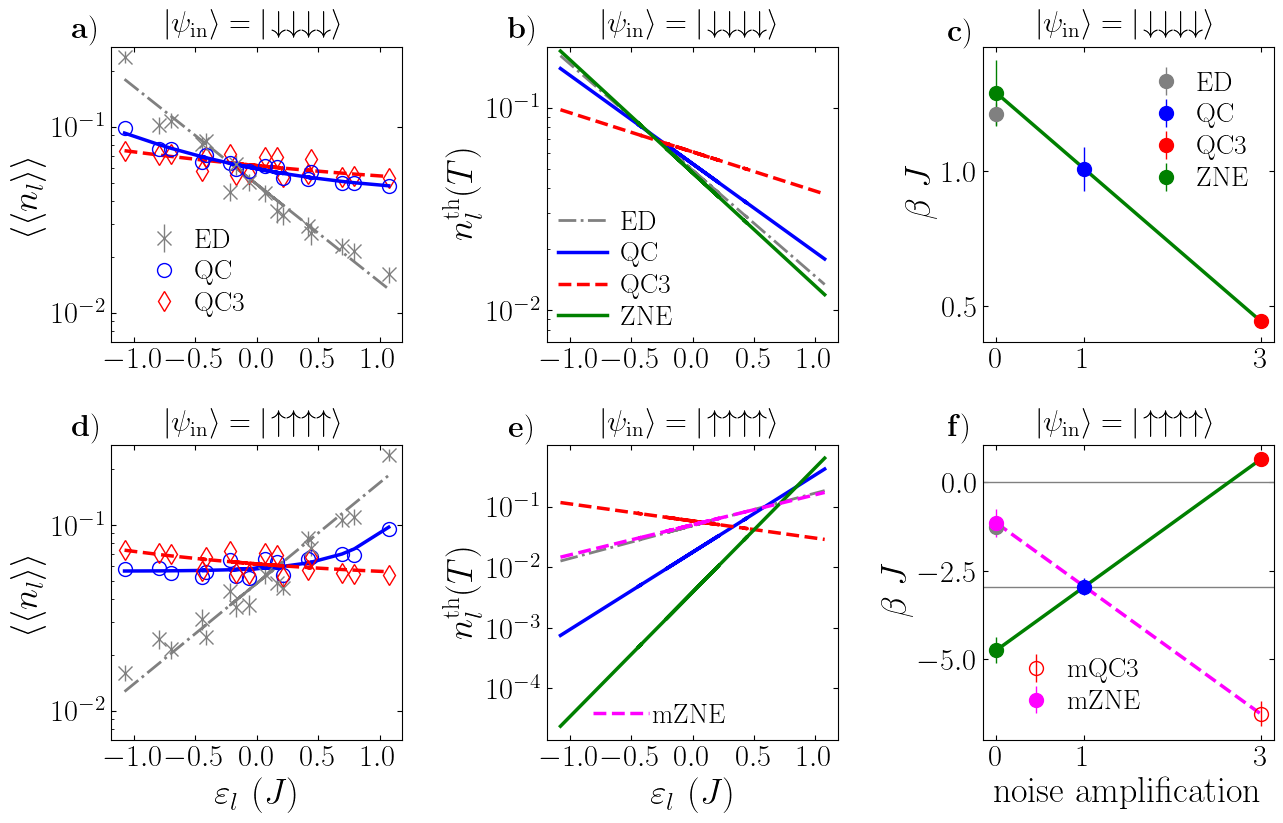

In [18]:
plt.rcParams.update(fparams3)

num_ind = 0

fig = plt.figure(figsize=(15, 9))
table = gridspec.GridSpec(ncols=3, nrows=2)


ax1 = fig.add_subplot(table[0, 0])

ax2 = fig.add_subplot(table[0, 1])
ax3 = fig.add_subplot(table[0, 2])

ax4 = fig.add_subplot(table[1, 0])

ax5 = fig.add_subplot(table[1, 1])
ax6 = fig.add_subplot(table[1, 2])


#ax1.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax1.set_ylabel(r'$\langle \langle n_l \rangle \rangle$')
ax1.set_title(r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$',pad=10)

ax1.errorbar(many_omegas,avg_pop_exact[0][2],fmt='x',yerr=std_pop_exact[0][2],color='gray',label='ED',elinewidth=1)
ax1.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[0][2][0]),'-.',color='gray',linewidth=2)
#ax1.errorbar(many_omegas,avg_pop_ZNE3[0][2],fmt='d',yerr=std_pop_ZNE3[0][2],color='red',label=r'QC $3 \times$noise',markerfacecolor='none',elinewidth=1)
ax1.plot(many_omegas,avg_pop_ZNE3[0][2],'d',color='red',label=r'QC3',markerfacecolor='none')

ax1.plot(many_omegas,thermal_distrib_global_depo(many_omegas,fit_ZNE3[0][2][0],fit_ZNE3[0][2][1]),'--',color='red')
#ax1.errorbar(many_omegas,avg_pop_RC[0][2],fmt='o',yerr=std_pop_RC[0][2],color='blue',label='QC',markerfacecolor='none',elinewidth=1)
ax1.plot(many_omegas,avg_pop_RC[0][2],'o',color='blue',label='QC',markerfacecolor='none')

ax1.plot(many_omegas,thermal_distrib_global_depo(many_omegas,fit_RC[0][2][0],fit_RC[0][2][1]),'-',color='blue')

ax1.set_yscale('log')
ax1.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax1.tick_params(which='minor', direction="in")

handles, labels = ax1.get_legend_handles_labels()
order = [2,1,0]
#ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 0, handletextpad=0.1, labelspacing = 0.25)
ax1.set_yticks([1e-2,1e-1])
ax1.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax1.set_ylim(7e-3,0.27)

ax1.text(-1.5, 0.3, r'${\bf a)}$')


#ax2.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax2.set_ylabel(r'$n_l^{\rm th}(T)$')
ax2.set_title(r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$',pad=10)

ax2.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[0][2][0]),'-.',color='gray',label=r' ED',linewidth=2)
ax2.plot(many_omegas,thermal_distrib(many_omegas,fit_RC[0][2][0]),'-',color='blue',label=r'QC')
ax2.plot(many_omegas,thermal_distrib(many_omegas,fit_ZNE3[0][2][0]),'--',color='red',label=r'QC3')
ax2.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta[0][2]),'-',color='green',label=r'ZNE')

ax2.set_yscale('log')
ax2.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax2.tick_params(which='minor', direction="in")
ax2.legend(loc = (0.,0.), handletextpad=0.5, labelspacing = 0.25,handlelength=1.75)
ax2.set_yticks([1e-2,1e-1])
ax2.set_ylim(7e-3,0.2)
ax2.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax2.text(-1.5, 0.22, r'${\bf b)}$')


r=[1,3]
beta=[fit_RC[0][2][0],fit_ZNE3[0][2][0]]
e=np.arange(0,3,0.01)
ax3.plot(e,ZNE_slope[0][2]*e+ZNE_beta[0][2],'-',color='green')
#ax3.set_xlabel(r'noise amplification')
ax3.set_ylabel(r'$\beta\ J$ ')
ax3.set_title(r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$',pad=10)
ax3.errorbar(0,fit_exact[0][2][0],fmt='o',yerr=np.sqrt(cov_exact[0][2][0][0]),color='gray',label='ED',elinewidth=1)
ax3.errorbar(r[0],beta[0],fmt='o',yerr=np.sqrt(cov_RC[0][2][0][0]),color='blue',label=r'QC',elinewidth=1)
ax3.errorbar(r[1],beta[1],fmt='o',yerr=np.sqrt(cov_ZNE3[0][2][0][0]),color='red',label=r'QC3',elinewidth=1)
ax3.errorbar(0,ZNE_beta[0][2],yerr=std_beta_ZNE[0][2],fmt='o',color='green',label=r'ZNE',elinewidth=1)

ax3.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax3.tick_params(which='minor', direction="in")
ax3.legend(loc = 0, handletextpad=0.1, labelspacing = 0.25)
#ax3.set_yticks(np.arange(0, 2.0, 0.2))
ax3.set_xticks([0,1,3])
ax3.text(-.55, 1.48, r'${\bf c)}$')



ax4.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax4.set_ylabel(r'$\langle \langle n_l \rangle \rangle$')
ax4.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$',pad=10)

ax4.errorbar(many_omegas,avg_pop_exact[1][2],fmt='x',yerr=std_pop_exact[1][2],color='gray',label='ED',elinewidth=1)
ax4.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[1][2][0]),'-.',color='gray',linewidth=2)
#ax4.errorbar(many_omegas,avg_pop_RC[1][2],fmt='d',yerr=std_pop_RC[1][2],color='blue',markerfacecolor='none',label='QC',elinewidth=1)
ax4.plot(many_omegas,avg_pop_RC[1][2],'o',color='blue',markerfacecolor='none',label='QC')
ax4.plot(many_omegas,thermal_distrib_global_depo(many_omegas,fit_RC[1][2][0],fit_RC[1][2][1]),'-',color='blue')
#ax4.errorbar(many_omegas,avg_pop_ZNE3[1][2],fmt='o',yerr=std_pop_ZNE3[1][2],markerfacecolor='none',color='red',label=r'QC $3 \times$noise',elinewidth=1)
ax4.plot(many_omegas,avg_pop_ZNE3[1][2],'d',markerfacecolor='none',color='red',label=r'QC $3 \times$noise')
ax4.plot(many_omegas,thermal_distrib_global_depo(many_omegas,fit_ZNE3[1][2][0],fit_ZNE3[1][2][1]),'--',color='red')
ax4.set_yscale('log')
ax4.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax4.tick_params(which='minor', direction="in")
#ax4.legend(loc = 0, handletextpad=0.1, labelspacing = 0.25)
ax4.set_yticks([1e-2,1e-1])
ax4.set_ylim(7e-3,0.27)
ax4.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax4.text(-1.5, 0.3, r'${\bf d)}$')


ax5.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax5.set_ylabel(r'$n_l^{\rm th}(T)$')
ax5.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$',pad=10)

ax5.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[1][2][0]),'-.',color='gray',linewidth=2)
ax5.plot(many_omegas,thermal_distrib(many_omegas,fit_RC[1][2][0]),'-',color='blue')
ax5.plot(many_omegas,thermal_distrib(many_omegas,fit_ZNE3[1][2][0]),'--',color='red')
ax5.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta[1][2]),'-',color='green')
ax5.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta_mirror[2]),'--',color='magenta',label=r'mZNE')

ax5.set_yscale('log')
ax5.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax5.tick_params(which='minor', direction="in")
ax5.legend(loc = (0.12,0.), handletextpad=0.1, labelspacing = 0.25,alignment='right')
ax5.set_yticks([0.0001,0.001,0.01,0.1])

ax5.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax5.text(-1.5, 1.4, r'${\bf e)}$')


r=[1,3]
beta=[fit_RC[1][2][0],fit_ZNE3[1][2][0]]
e=np.arange(0,3,0.01)
ax6.axhline(beta[0],xmin=-.1,xmax=3.1,color='gray',linewidth=1)
ax6.axhline(0,xmin=-.1,xmax=3.1,color='gray',linewidth=1)
ax6.plot(e,ZNE_slope[1][2]*e+ZNE_beta[1][2],'-',color='green')
ax6.errorbar(0,ZNE_beta[1][2],yerr=std_beta_ZNE[1][2],fmt='o',color='green',elinewidth=1)
ax6.set_xlabel(r'noise amplification')
ax6.set_ylabel(r'$\beta\ J$ ')
ax6.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$',pad=10)
ax6.errorbar(0,fit_exact[1][2][0],fmt='o',yerr=np.sqrt(cov_exact[1][2][0][0]),color='gray',elinewidth=1)
ax6.errorbar(r[0],beta[0],fmt='o',yerr=np.sqrt(cov_RC[1][2][0][0]),color='blue',elinewidth=1)
ax6.errorbar(r[1],beta[1],fmt='o',yerr=np.sqrt(cov_ZNE3[1][2][0][0]),color='red',elinewidth=1)
ax6.errorbar(r[1],fit_ZNE3_mirror[2][0],fmt='o',yerr=std_ZNE3_mirror[2],markerfacecolor='none', markeredgecolor='red',ecolor='red',label=r'mQC3',elinewidth=1)
ax6.plot(e,ZNE_slope_mirror[2]*e+ZNE_beta_mirror[2],'--',color='magenta')


ax6.errorbar(0,ZNE_beta_mirror[2],yerr=std_beta_ZNE_mirror[2],fmt='o',color='magenta',label=r'mZNE',elinewidth=1)

ax6.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax6.tick_params(which='minor', direction="in")
ax6.legend(loc = 0, handletextpad=0.1, labelspacing = 0.25)
ax6.set_xticks([0,1,3])
ax6.set_yticks([-5,-2.5,0])

ax6.text(-.55, 1.3, r'${\bf f)}$')

table.update(wspace=0.5,hspace=0.35)
plt.subplots_adjust()
plt.savefig('figure/populations_and_temperature.pdf')

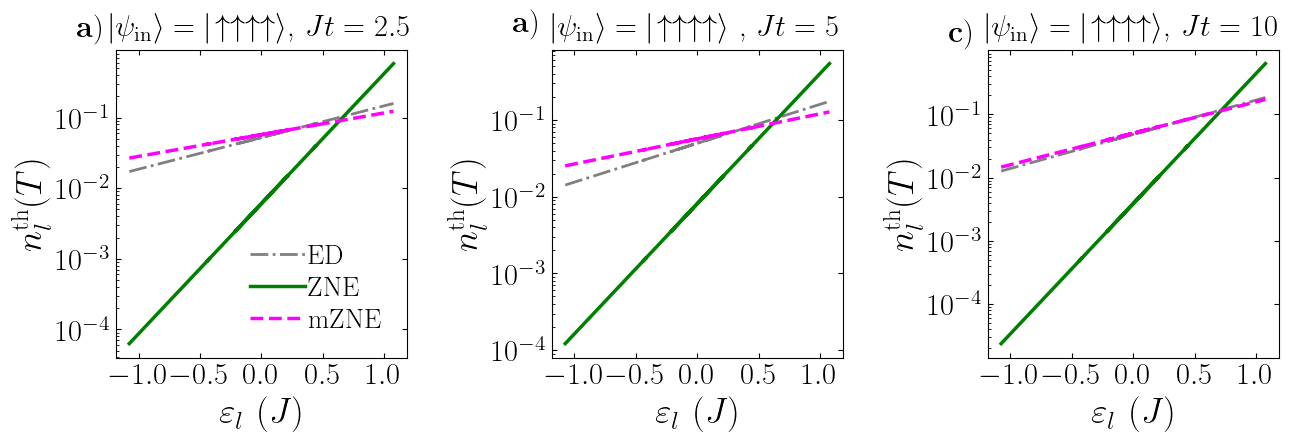

In [19]:
plt.rcParams.update(fparams3)

num_ind = 0

fig = plt.figure(figsize=(15, 4))
table = gridspec.GridSpec(ncols=3, nrows=1)


ax1 = fig.add_subplot(table[0])

ax2 = fig.add_subplot(table[1])
ax3 = fig.add_subplot(table[2])


ax1.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax1.set_ylabel(r'$n_l^{\rm th}(T)$')
ax1.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$, $Jt=2.5$',pad=10)

ax1.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[1][0][0]),'-.',color='gray',label='ED',linewidth=2)
#ax1.plot(many_omegas,thermal_distrib(many_omegas,fit_RC[1][0][0]),'-',color='blue',label='QC')
#ax1.plot(many_omegas,thermal_distrib(many_omegas,fit_ZNE3[1][0][0]),'--',color='red',label='QC3')
ax1.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta[1][0]),'-',color='green',label='ZNE')
ax1.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta_mirror[0]),'--',color='magenta',label=r'mZNE')

ax1.set_yscale('log')
ax1.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax1.tick_params(which='minor', direction="in")
ax1.legend(loc = 0, handletextpad=0.1, labelspacing = 0.25,alignment='right')
ax1.set_yticks([0.0001,0.001,0.01,0.1])

ax1.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax1.text(-1.5, 1.4, r'${\bf a)}$')


ax2.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax2.set_ylabel(r'$n_l^{\rm th}(T)$')
ax2.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$ , $Jt=5$',pad=10)

ax2.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[1][1][0]),'-.',color='gray',label='ED',linewidth=2)
#ax2.plot(many_omegas,thermal_distrib(many_omegas,fit_RC[1][1][0]),'-',color='blue',label='QC')
#ax2.plot(many_omegas,thermal_distrib(many_omegas,fit_ZNE3[1][1][0]),'--',color='red',label='QC3')
ax2.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta[1][1]),'-',color='green',label='ZNE')
ax2.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta_mirror[1]),'--',color='magenta',label=r'mZNE')

ax2.set_yscale('log')
ax2.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax2.tick_params(which='minor', direction="in")
#ax1.legend(loc = (0.12,0.), handletextpad=0.1, labelspacing = 0.25,alignment='right')
ax2.set_yticks([0.0001,0.001,0.01,0.1])

ax2.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax2.text(-1.5, 1.4, r'${\bf a)}$')


ax3.set_xlabel(r'$\varepsilon_l\,\, (J)$')
ax3.set_ylabel(r'$n_l^{\rm th}(T)$')
ax3.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$, $Jt=10$',pad=10)

ax3.plot(many_omegas,thermal_distrib(many_omegas,fit_exact[1][2][0]),'-.',color='gray',linewidth=2)
#ax3.plot(many_omegas,thermal_distrib(many_omegas,fit_RC[1][2][0]),'-',color='blue')
#ax3.plot(many_omegas,thermal_distrib(many_omegas,fit_ZNE3[1][2][0]),'--',color='red')
ax3.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta[1][2]),'-',color='green')
ax3.plot(many_omegas,thermal_distrib(many_omegas,ZNE_beta_mirror[2]),'--',color='magenta',label=r'mZNE')

ax3.set_yscale('log')
ax3.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax3.tick_params(which='minor', direction="in")
#ax3.legend(loc = (0.12,0.), handletextpad=0.1, labelspacing = 0.25,alignment='right')
ax3.set_yticks([0.0001,0.001,0.01,0.1])

ax3.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax3.text(-1.5, 1.4, r'${\bf c)}$')



table.update(wspace=0.5,hspace=0.5)
plt.subplots_adjust()


In [20]:


#mean energy
mean_energy_exact=list(list(list(sum(pop_exact[i][d][t][p]*many_omegas[p] for p in range(2**nb_qubits)) for t in range(len(t_array))) for d in range(nr)) for i in range(len(initial_states)))
npy_pop_exact=np.array(pop_exact)
avg_pop_exact_bis=list(list(list(np.mean(npy_pop_exact[i,:,t,p]) for p in range(2**nb_qubits)) for t in range(len(t_array))) for i in range(len(initial_states)))
std_pop_exact_bis=list(list(list(np.std(npy_pop_exact[i,:,t,p],ddof=1)/np.sqrt(nr) for p in range(2**nb_qubits)) for t in range(len(t_array))) for i in range(len(initial_states)))


fit_dyn=[None]*len(initial_states)
cov_dyn=[None]*len(initial_states)
for i in range(len(initial_states)):
    fit_dyn_temp=[]
    cov_dyn_temp=[]
    for t in range(len(t_array)):
        opt_curve=scipy.optimize.curve_fit(thermal_distrib_func,many_omegas,avg_pop_exact_bis[i][t],sigma=std_pop_exact_bis[i][t],absolute_sigma=True) 
        fit_dyn_temp.append(opt_curve[0])
        cov_dyn_temp.append(opt_curve[1])
    fit_dyn[i]=fit_dyn_temp.copy()
    cov_dyn[i]=cov_dyn_temp.copy()
    
    
mean_energy_exact_bis=list(list(sum(avg_pop_exact_bis[i][t][p]*many_omegas[p] for p in range(2**nb_qubits)) for t in range(len(t_array))) for i in range(len(initial_states)))
mean_energy_noiseless=list(list(sum(avg_pop_noiseless[i][s][p]*many_omegas[p] for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
mean_energy_fit_noiseless=list(list(sum(thermal_distrib_func(energy,fit_noiseless[i][s][0])*energy for energy in many_omegas) for s in range(len(sessions[i]))) for i in range(len(initial_states)))

mean_energy_RC=list(list(sum(avg_pop_RC[i][s][p]*many_omegas[p] for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
mean_energy_fit=list(list(sum(thermal_distrib_func(energy,fit_RC[i][s][0])*energy for energy in many_omegas) for s in range(len(sessions[i]))) for i in range(len(initial_states)))

mean_energy_ZNE3=list(list(sum(avg_pop_ZNE3[i][s][p]*many_omegas[p] for p in range(2**nb_qubits)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
mean_energy_fit_ZNE3=list(list(sum(thermal_distrib_func(energy,fit_ZNE3[i][s][0])*energy for energy in many_omegas) for s in range(len(sessions[i]))) for i in range(len(initial_states)))

#mean energy ZNE on beta fitted
mean_energy_beta_fit=list(list(sum(thermal_distrib_func(energy,ZNE_beta[i][s])*energy for energy in many_omegas) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
mean_energy_beta_fit_mirror=list(sum(thermal_distrib_func(energy,ZNE_beta_mirror[s])*energy for energy in many_omegas) for s in range(len(sessions[1])))

#mean energy for the fit (red curve)

mean_energy_fit_exact=list(list(sum(thermal_distrib_func(energy,fit_dyn[i][t][0])*energy for energy in many_omegas) for t in range(len(t_array))) for i in range(len(initial_states)))

#time average for t>2.5
time_avg_mean_energy_fit_exact=list([np.mean(mean_energy_fit_exact[i][250:])]*len(t_array[250:]) for i in range(len(initial_states)))


# energy fluctuation
var_energy_exact=list(list(list(sum(pop_exact[i][d][t][p]*many_omegas[p]**2 for p in range(2**nb_qubits))-mean_energy_exact[i][d][t]**2 for t in range(len(t_array))) for d in range(nr)) for i in range(len(initial_states)))

var_energy_exact_bis=list(list(sum(avg_pop_exact_bis[i][t][p]*many_omegas[p]**2 for p in range(2**nb_qubits))-mean_energy_exact_bis[i][t]**2 for t in range(len(t_array))) for i in range(len(initial_states)))
var_energy_noiseless=list(list(sum(avg_pop_noiseless[i][s][p]*many_omegas[p]**2 for p in range(2**nb_qubits))-mean_energy_noiseless[i][s]**2 for s in range(len(sessions[i]))) for i in range(len(initial_states)))
var_energy_RC=list(list(sum(avg_pop_RC[i][s][p]*many_omegas[p]**2 for p in range(2**nb_qubits))-mean_energy_RC[i][s]**2 for s in range(len(sessions[i]))) for i in range(len(initial_states)))
var_energy_fit=list(list(sum(thermal_distrib_func(energy,fit_RC[i][s][0])*energy**2 for energy in many_omegas)-mean_energy_fit[i][s]**2 for s in range(len(sessions[i]))) for i in range(len(initial_states)))

var_energy_ZNE3=list(list(sum(avg_pop_ZNE3[i][s][p]*many_omegas[p]**2 for p in range(2**nb_qubits))-mean_energy_ZNE3[i][s]**2 for s in range(len(sessions[i]))) for i in range(len(initial_states)))
var_energy_fit_ZNE3=list(list(sum(thermal_distrib_func(energy,fit_ZNE3[i][s][0])*energy**2 for energy in many_omegas)-mean_energy_fit_ZNE3[i][s]**2 for s in range(len(sessions[i]))) for i in range(len(initial_states)))

var_energy_beta_fit=list(list(sum(thermal_distrib_func(energy,ZNE_beta[i][s])*energy**2 for energy in many_omegas)-mean_energy_beta_fit[i][s]**2 for s in range(len(sessions[i]))) for i in range(len(initial_states)))
var_energy_beta_fit_mirror=list(sum(thermal_distrib_func(energy,ZNE_beta_mirror[s])*energy**2 for energy in many_omegas)-mean_energy_beta_fit_mirror[s]**2 for s in range(len(sessions[i])))

# energy fluctuation for the fit
var_energy_fit_exact=list(list(sum(thermal_distrib_func(energy,fit_dyn[i][t][0])*energy**2 for energy in many_omegas)-mean_energy_fit_exact[i][t]**2 for t in range(len(t_array))) for i in range(len(initial_states)))


#standard deviations
std_mean_energy_noiseless=list(list(np.sqrt(sum(std_pop_noiseless[i][s][p]**2*many_omegas[p]**2 for p in range(2**nb_qubits))) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_mean_energy_fit_noiseless=list(list(np.abs(sum(thermal_distrib_func(energy,fit_noiseless[i][s][0]+np.sqrt(cov_noiseless[i][s][0][0]))*energy for energy in many_omegas)-mean_energy_fit_noiseless[i][s]) for s in range(len(sessions[i])))for i in range(len(initial_states)))

std_mean_energy_RC=list(list(np.sqrt(sum(std_pop_RC[i][s][p]**2*many_omegas[p]**2 for p in range(2**nb_qubits))) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_mean_energy_fit=list(list(var_energy_fit[i][s]*np.sqrt(cov_RC[i][s][0][0]) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_mean_energy_ZNE3=list(list(np.sqrt(sum(std_pop_ZNE3[i][s][p]**2*many_omegas[p]**2 for p in range(2**nb_qubits))) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_mean_energy_fit_ZNE3=list(list(var_energy_fit_ZNE3[i][s]*np.sqrt(cov_ZNE3[i][s][0][0])for s in range(len(sessions[i])))for i in range(len(initial_states)))
std_mean_energy_beta_fit=list(list(var_energy_beta_fit[i][s]*std_beta_ZNE[i][s] for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_mean_energy_beta_fit_mirror=list(var_energy_beta_fit_mirror[s]*std_beta_ZNE_mirror[s] for s in range(len(sessions[1]))) 


std_var_energy_RC=list(list(np.sqrt(sum(std_pop_RC[i][s][p]**2*(many_omegas[p]-mean_energy_RC[i][s])**4 +4*(many_omegas[p]-mean_energy_RC[i][s])**2*std_mean_energy_RC[i][s]**2*avg_pop_RC[i][s][p]**2 for p in range(2**nb_qubits))) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_var_energy_fit=list(list(np.sqrt(cov_RC[i][s][0][0])*np.abs(sum(thermal_distrib_func(energy,fit_RC[i][s][0])*(energy-mean_energy_RC[i][s])**3 for energy in many_omegas)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_var_energy_beta_fit=list(list(std_beta_ZNE[i][s]*np.abs(sum(thermal_distrib_func(energy,ZNE_beta[i][s])*(energy-mean_energy_beta_fit[i][s])**3 for energy in many_omegas)) for s in range(len(sessions[i]))) for i in range(len(initial_states)))
std_var_energy_beta_fit_mirror=list(std_beta_ZNE_mirror[s]*np.abs(sum(thermal_distrib_func(energy,ZNE_beta_mirror[s])*(energy-mean_energy_beta_fit_mirror[s])**3 for energy in many_omegas)) for s in range(len(sessions[1])))


time_avg_var_energy_fit_exact=list([np.mean(var_energy_fit_exact[i][250:])]*len(t_array[250:]) for i in range(len(initial_states)))





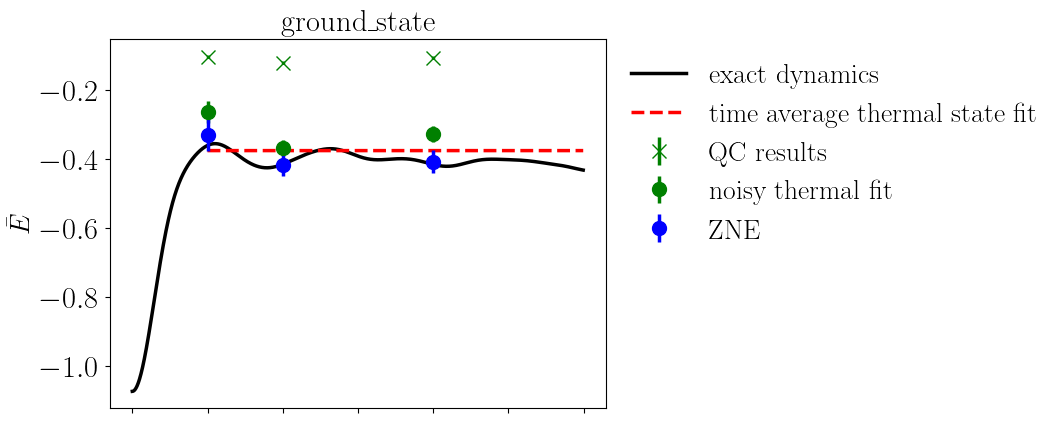

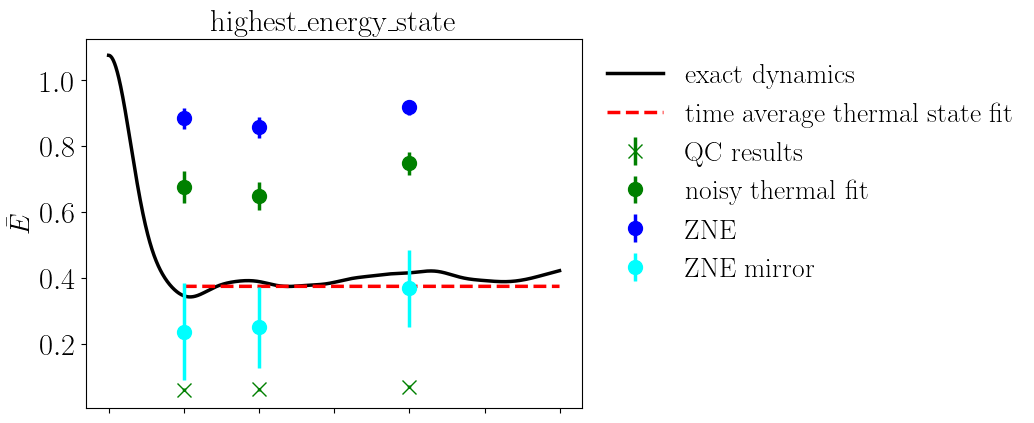

In [21]:
#Plot mean energy
for i in range(len(initial_states)):
    plt.plot(t_array,mean_energy_exact_bis[i],'-',color='black',label='exact dynamics')
    plt.plot(t_array[250:],time_avg_mean_energy_fit_exact[i],'--',color='red',label='time average thermal state fit')


    plt.errorbar(T,mean_energy_RC[i],fmt='x',yerr=std_mean_energy_RC[i],color='green',label='QC results')
    plt.errorbar(T,mean_energy_fit[i],fmt='o',yerr=std_mean_energy_fit[i],color='green',label='noisy thermal fit')
    plt.errorbar(T,mean_energy_beta_fit[i],fmt='o',yerr=std_mean_energy_beta_fit[i],color='blue',label=r'ZNE')
    if i==1:
        plt.errorbar(T,mean_energy_beta_fit_mirror,fmt='o',yerr=std_mean_energy_beta_fit_mirror,color='cyan',label=r'ZNE mirror')
    
    plt.xticks(ticks=[0,2.5,5,7.5,10,12.5,15],labels=[" "]*7)
    #plt.xlabel(r'J$\tau$',fontsize=20)
    plt.ylabel(r'$\bar{E}$',fontsize=20)
    sigma=1#standard deviation of the coupling strength's gaussian distribution
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(initial_states[i])
    plt.show()

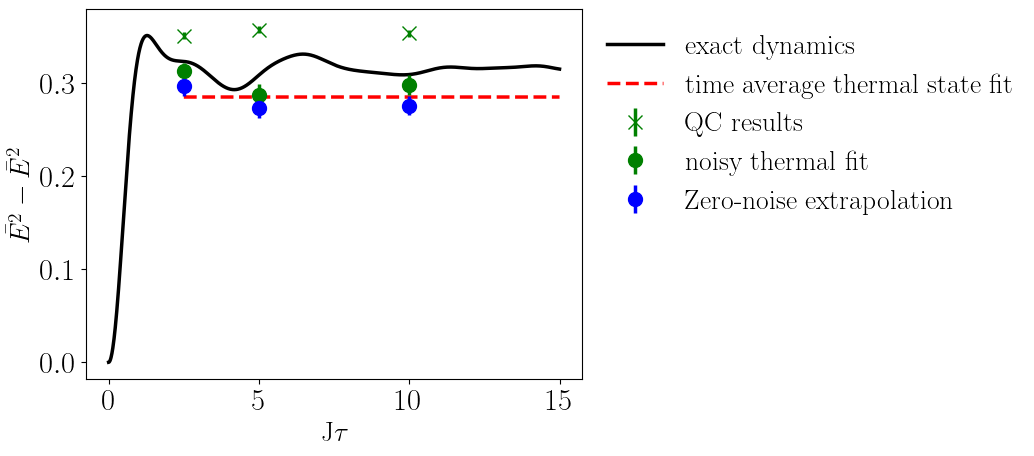

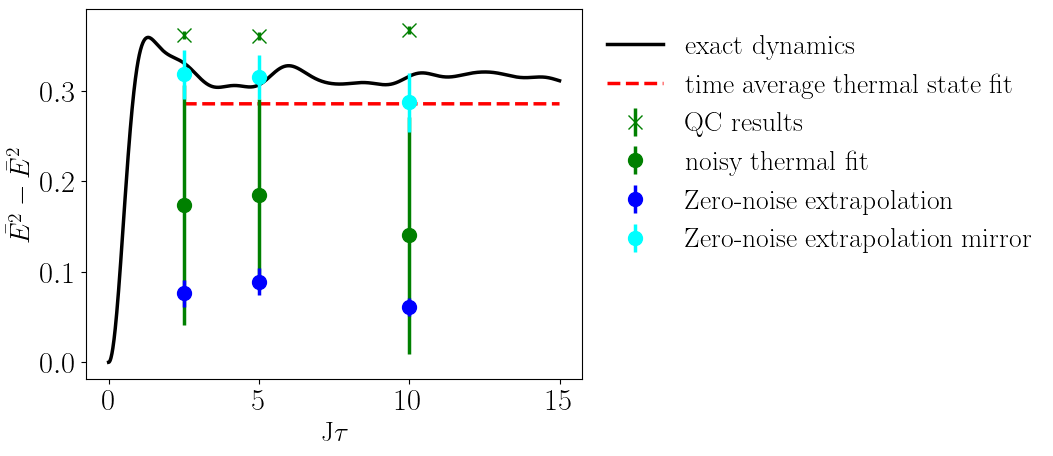

In [22]:
# plot energy fluctuation

for i in range(len(initial_states)):

    plt.plot(t_array,var_energy_exact_bis[i],'-',color='black',label='exact dynamics')

    plt.plot(t_array[250:],time_avg_var_energy_fit_exact[i],'--',color='red',label='time average thermal state fit')
    plt.errorbar(T,var_energy_RC[i],fmt='x',yerr=std_var_energy_RC[i],color='green',label='QC results')
    plt.errorbar(T,var_energy_fit[i],fmt='o',yerr=std_var_energy_fit[i],color='green',label='noisy thermal fit')
    plt.errorbar(T,var_energy_beta_fit[i],fmt='o',yerr=std_var_energy_beta_fit[i],color='blue',label='Zero-noise extrapolation')
    if i==1:
        plt.errorbar(T,var_energy_beta_fit_mirror,fmt='o',yerr=std_var_energy_beta_fit_mirror,color='cyan',label='Zero-noise extrapolation mirror')
    
    plt.xlabel(r'J$\tau$',fontsize=20)
    plt.ylabel(r'$\bar{E^2} -\bar{E}^2$',fontsize=20)
    sigma=1#standard deviation of the coupling strength's gaussian distribution
    #plt.title(label=r' J$\tau$='+str(round(sigma*T[s],2)),fontsize=20)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

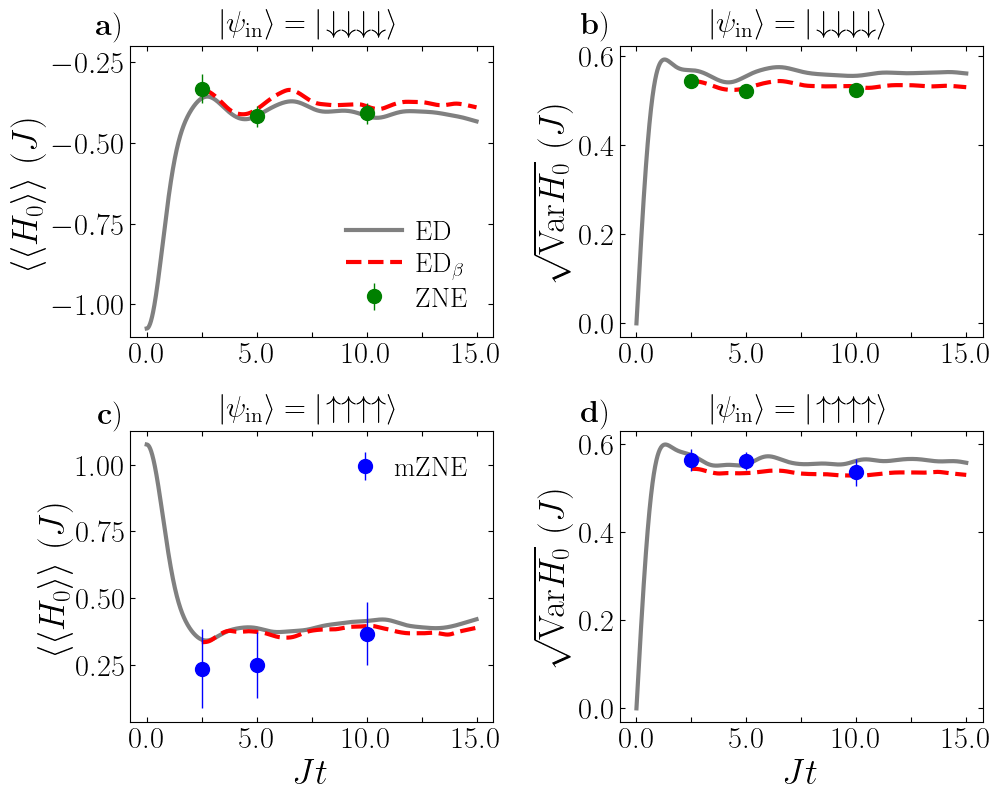

In [23]:
plt.rcParams.update(fparams3)

num_ind = 0

fig = plt.figure(figsize=(11, 10))
table = gridspec.GridSpec(ncols=2, nrows=2)


ax1 = fig.add_subplot(table[0, 0])

ax2 = fig.add_subplot(table[0, 1])

ax3 = fig.add_subplot(table[1, 0])

ax4 = fig.add_subplot(table[1, 1])


#ax1.set_xlabel(r'$Jt$')
ax1.set_ylabel(r'$\langle \langle H_0\rangle\rangle\,\, (J)$')
ax1.set_title(r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$',pad=10)
ax1.plot(t_array,mean_energy_exact_bis[0],'-',color='gray',linewidth=3,label='ED')
ax1.plot(t_array[250:],mean_energy_fit_exact[0][250:],'--',color='red',linewidth=3,label=r'ED$_\beta$')
ax1.errorbar(T,mean_energy_beta_fit[0],fmt='o',yerr=std_mean_energy_beta_fit[0],color='green',label='ZNE',elinewidth=1)
    
ax1.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax1.tick_params(which='minor', direction="in")
ax1.legend(loc = 0, handletextpad=0.5, labelspacing = 0.25)
#ax1.set_yticks([0.008,0.01,0.02,0.05,0.1,0.2])
ax1.set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
ax1.set_xticklabels(['0.0', ' ', '5.0', ' ', '10.0', ' ', '15.0'])
ax1.text(-2.3, -0.165, r'${\bf a)}$')
ax1.set_ylim(-1.1,-0.2)
ax1.set_aspect(0.8/ax1.get_data_ratio(), adjustable='box')


#ax2.set_xlabel(r'$Jt$')
ax2.set_ylabel(r' $\sqrt{{\rm Var} H_0}\,\, (J)$')
ax2.set_title(r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$',pad=10)
ax2.plot(t_array,np.sqrt(var_energy_exact_bis[0]),'-',linewidth=3,color='gray',label='ED')
ax2.plot(t_array[250:],np.sqrt(var_energy_fit_exact[0][250:]),'--',linewidth=3,color='red',label='ED th. fit')

ax2.errorbar(T,np.sqrt(var_energy_beta_fit[0]),fmt='o',yerr=std_var_energy_beta_fit[0]/(2*np.sqrt(var_energy_beta_fit[0])),color='green',label='ZNE',elinewidth=1)
    

ax2.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax2.tick_params(which='minor', direction="in")
#ax2.legend(loc = 0, handletextpad=0.5, labelspacing = 0.25)
#ax1.set_yticks([0.008,0.01,0.02,0.05,0.1,0.2])
ax2.set_xticks([0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0])
ax2.set_xticklabels(['0.0', ' ', '5.0', ' ', '10.0', ' ', '15.0'])

ax2.text(-2.5, 0.65, r'${\bf b)}$')
ax2.set_aspect(0.8/ax2.get_data_ratio(), adjustable='box')



ax3.set_xlabel(r'$Jt$')
ax3.set_ylabel(r'$\langle \langle H_0\rangle\rangle\,\, (J)$',labelpad=2)
ax3.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$',pad=10)
ax3.plot(t_array,mean_energy_exact_bis[1],'-',color='gray',linewidth=3)
ax3.plot(t_array[250:],mean_energy_fit_exact[1][250:],'--',color='red',linewidth=3)
#ax3.errorbar(T,mean_energy_beta_fit[1],fmt='o',yerr=std_mean_energy_beta_fit[1],color='green',elinewidth=1)
ax3.errorbar(T,mean_energy_beta_fit_mirror,fmt='o',yerr=std_mean_energy_beta_fit_mirror,color='blue',label=r'mZNE',elinewidth=1)
    
ax3.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax3.tick_params(which='minor', direction="in")
ax3.legend(loc = 1, handletextpad=0.05, labelspacing = 0.25)
#ax1.set_yticks([0.008,0.01,0.02,0.05,0.1,0.2])
ax3.set_xticks([0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0])
ax3.set_xticklabels(['0.0', ' ', '5.0', ' ', '10.0', ' ', '15.0'])
ax3.set_yticks([0.25, .5, .75, 1.0,])
ax3.set_yticklabels(['0.25', '0.50', '0.75', '1.00'])

ax3.text(-2.2, 1.15, r'${\bf c)}$')
ax3.set_aspect(0.8/ax3.get_data_ratio(), adjustable='box')


ax4.set_xlabel(r'$Jt$')
ax4.set_ylabel(r' $\sqrt{{\rm Var} H_0}\,\, (J)$')
ax4.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$',pad=10)
ax4.plot(t_array,np.sqrt(var_energy_exact_bis[1]),'-',linewidth=3,color='gray')
ax4.plot(t_array[250:],np.sqrt(var_energy_fit_exact[1][250:]),'--',linewidth=3,color='red')

#ax4.errorbar(T,np.sqrt(var_energy_beta_fit[1]),fmt='o',yerr=std_var_energy_beta_fit[1]/(2*np.sqrt(var_energy_beta_fit[1])),color='green',elinewidth=1)
ax4.errorbar(T,np.sqrt(var_energy_beta_fit_mirror),fmt='o',yerr=std_var_energy_beta_fit_mirror/(2*np.sqrt(var_energy_beta_fit_mirror)),color='blue',label='mZNE',elinewidth=1)


ax4.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax4.tick_params(which='minor', direction="in")
#ax4.legend(loc = 0, handletextpad=0.1, labelspacing = 0.25)
ax4.set_xticks([0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0])
ax4.set_xticklabels(['0.0', ' ', '5.0', ' ', '10.0', ' ', '15.0'])

ax4.text(-2.5, 0.65, r'${\bf d)}$')
ax4.set_aspect(0.8/ax4.get_data_ratio(), adjustable='box')

table.update(wspace=0.35,hspace=0.)
plt.subplots_adjust()
plt.savefig('figure/mean_and_energy_fluctuation.pdf')

In [24]:
#ZNE green points  panel a
mean_energy_beta_fit[0] 

[-0.33093806259057734, -0.4170325566727279, -0.4082686082407108]

In [25]:
#ZNE error bar green points  panel a
std_mean_energy_beta_fit[0]

[0.0455388724271267, 0.03343743761007129, 0.033544827244346445]

In [26]:
#mZNE blue points  panel c
mean_energy_beta_fit_mirror

[0.2359835997237131, 0.2497174061473481, 0.368165410047681]

In [27]:
#mZNE error bar blue points  panel c
std_mean_energy_beta_fit_mirror

[0.14743304119652287, 0.12369484679764328, 0.11743888467400537]